# Anylsis Pipeline for the project
Team Dog: Maximilian Bernhardt, Patrick Ebner, Simon Enkel, Claudius Hilser, Enno Schwenk

* **Beschreibung der Pipeline nach Fertigstellung**



### Imports

In [13]:
#Import packages
import numpy as np
import pandas as pd
import os
from collections import Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

### Data read-in

In [85]:
# Define path for folder with participant data
folder_path = '../data/raw'

# Save all filenames in a list
tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]


### Defining variables, dataframes and lists

In [78]:
# Define target coordinates
target_coords = [
    (-320, 0), (320, 0), (-277, -160), (277, 160), 
    (0, 320), (0, -320), (277, -160), (-277, 160), 
    (-160, -277), (160, 277), (160, -277), (-160, 277)
]
# Define target names according to the coordinates
target_names = [
    'nine', 'three', 'eight', 'two', 
    'twelve', 'six', 'four', 'ten', 
    'seven', 'one', 'five', 'eleven'
]
target_coord_to_name = dict(zip(target_coords, target_names))

# Ensure the dataframe is in the correct order from one to twelve
target_order = [
    'one', 'two', 'three', 'four', 
    'five', 'six', 'seven', 'eight', 
    'nine', 'ten', 'eleven', 'twelve'
]

# Save screen-dimensions and threshold to define whether a target was fixated or not
screen_width = 1920
screen_height = 1080
threshold = 50

# Initialize an empty dataframe for the sums of fixations
sum_df = pd.DataFrame(columns=['Coordinate', 'Count'])


### Defining Functions
All functions used for the visualizing the results of the research are defined in the following blocks. 

 
**is_within_threshold(row, target_coords, threeshold)** \
This function checks whether the fixation is on a stimulus and inside a given threshold.


**find_closest_target(row, target_coords, threshold)** \
The second function finds the stimuli which the the fixation lands on.




In [88]:
# Function 1
# Function to check if the fixation is within the threshold distance from any target coordinate
def is_within_threshold(row, target_coords, threshold):
    x, y = row['x_coord'], row['y_coord']
    for tx, ty in target_coords:
        if np.sqrt((x - tx)**2 + (y - ty)**2) <= threshold:
            return True
    return False


# Function 2
# Function to find the closest target coordinate within the threshold distance
def find_closest_target(row, target_coords, threshold):
    x, y = row['x_coord'], row['y_coord']
    for tx, ty in target_coords:
        if np.sqrt((x - tx)**2 + (y - ty)**2) <= threshold:
            return (tx, ty)
    return None


### Data Preprocessing
In the data preprocessing, the data gets prepared for the analysis following in this script. Therefore, the time gets normalized to start at 0 and the fixations are extracted. Afterwards, the valid fixations are anaylzed for their positions and added to the position-number where the participant focussed.

In [86]:
# Initialize an empty dataframe for the sums of fixations
sum_df = pd.DataFrame(columns=['Coordinate', 'Count'])

# Iterate through all .tsv-Files and sum up the fixations for the current file in sum_df
for file in tsv_files:
    # Load the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t')

    # Normalize the time for the current file to begin at zero
    df['TIME'] = df['TIME'] - df['TIME'].iloc[0]

    # Create a new dataframe to save all fixations
    df_fixations = df.groupby('FPOGID').agg({#noch ändern dass das letzte verwendet wird anstatt median
        'FPOGX': 'median',
        'FPOGY': 'median',
        'TIME': 'median',
        #'USER': 'first'  # Or another method to handle multiple users
    }).reset_index()

    df_fixations['x_coord'] = (df_fixations['FPOGX'] - 0.5) * screen_width
    df_fixations['y_coord'] = (df_fixations['FPOGY'] - 0.5) * screen_height

    # Find the indices of 'SHOW_STIMULUS' events
    show_stimulus_times = df[df['USER'] == 'SHOW_STIMULUS']['TIME'].values

    # Get the 'TIME' values for each 'SHOW_STIMULUS' event from data_tsv
    #show_stimulus_times = data_tsv[data_tsv['USER'] == 'SHOW_STIMULUS']['TIME'].values

    # Initialize a list to store the target coordinates of first fixations
    first_fixation_targets = []

    # Iterate over each 'SHOW_STIMULUS' event time
    for show_time in show_stimulus_times:
        # Filter fixations that occur after the 'SHOW_STIMULUS' event time
        valid_fixations = df_fixations[df_fixations['TIME'] > show_time]
        
        # Find the first fixation within the threshold distance
        for idx, row in valid_fixations.iterrows():
            target = find_closest_target(row, target_coords, threshold)
            if target:
                first_fixation_targets.append(target)
                break

    # Map the target coordinates to their descriptive names
    first_fixation_targets_named = [target_coord_to_name[target] for target in first_fixation_targets]

    # Count the occurrences of each target coordinate name
    target_counts = Counter(first_fixation_targets_named)

    # Convert the counts to a DataFrame for visualization
    target_counts_df = pd.DataFrame(list(target_counts.items()), columns=['Coordinate', 'Count'])


    target_counts_df['Coordinate'] = pd.Categorical(target_counts_df['Coordinate'], categories=target_order, ordered=True)
    target_counts_df = target_counts_df.sort_values('Coordinate')

    # Add number of fixations to the dataframe sum_df which consists of all fixations
    if sum_df.empty:
        sum_df = target_counts_df.copy()
    else:
        sum_df = sum_df.set_index('Coordinate').add(target_counts_df.set_index('Coordinate'), fill_value=0).reset_index()

### Data Vizualization
In the following parts, the data gets visualized using different types of plots. Target of these plots is to deal with the topic: "Does diagonal positioning of stimuli eliminate the left-bias in viewing images?​" 


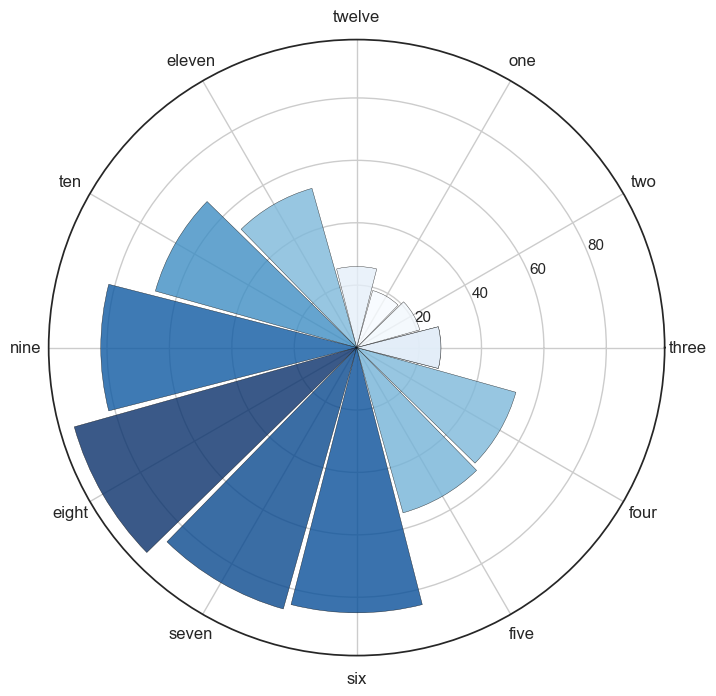

In [87]:
# Die Kategorien in der gewünschten Reihenfolge umsortieren
categories = ['three', 'two', 'one','twelve', 'eleven', 'ten', 'nine', 'eight', 'seven', 'six', 'five', 'four']

# Die Werte in der Reihenfolge der Kategorien anordnen
values = sum_df.set_index('Coordinate').reindex(categories)['Count'].fillna(0).values

# Anzahl der Kategorien
num_vars = len(categories)

# Winkel für jedes Segment berechnen
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Werte für den geschlossenen Radialplot erweitern
values = np.concatenate((values,[values[0]]))
angles += angles[:1]

# Colormap definieren (eine Farbe mit unterschiedlichen Intensitäten)
cmap = plt.cm.Blues  # Blau als Basisfarbe
norm = Normalize(vmin=min(values), vmax=max(values))
colors = cmap(norm(values))

# Plot erstellen
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Balken für jedes Segment erstellen
bars = ax.bar(angles, values, width=0.5, color=colors, edgecolor='black', linewidth=0.3, alpha=0.8)

# Kategorien als Beschriftungen setzen
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, ha='center')

plt.show()